# Open-Domain QA on Tables
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepset-ai/haystack/blob/master/tutorials/Tutorial15_TableQA.ipynb)

This tutorial shows you how to perform question-answering on tables using the `TableTextRetriever` or `ElasticsearchRetriever` as retriever node and the `TableReader` as reader node.

### Prepare environment

#### Colab: Enable the GPU runtime
Make sure you enable the GPU runtime to experience decent speed in this tutorial.
**Runtime -> Change Runtime type -> Hardware accelerator -> GPU**

<img src="https://raw.githubusercontent.com/deepset-ai/haystack/master/docs/img/colab_gpu_runtime.jpg">

In [ ]:
# Make sure you have a GPU running
!nvidia-smi

In [ ]:
# Install the latest release of Haystack in your own environment
#! pip install farm-haystack

# Install the latest master of Haystack
!pip install --upgrade pip
!pip install git+https://github.com/deepset-ai/haystack.git#egg=farm-haystack[colab]

# The TaPAs-based TableReader requires the torch-scatter library
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html

# Install pygraphviz for visualization of Pipelines
!apt install libgraphviz-dev
!pip install pygraphviz

### Start an Elasticsearch server
You can start Elasticsearch on your local machine instance using Docker. If Docker is not readily available in your environment (e.g. in Colab notebooks), then you can manually download and execute Elasticsearch from source.

In [ ]:
# Recommended: Start Elasticsearch using Docker via the Haystack utility function
from haystack.utils import launch_es

launch_es()

In [ ]:
# In Colab / No Docker environments: Start Elasticsearch from source
! wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.9.2-linux-x86_64.tar.gz -q
! tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz
! chown -R daemon:daemon elasticsearch-7.9.2

import os
from subprocess import Popen, PIPE, STDOUT

es_server = Popen(
    ["elasticsearch-7.9.2/bin/elasticsearch"], stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1)  # as daemon
)
# wait until ES has started
! sleep 30

In [ ]:
# Connect to Elasticsearch
from haystack.document_stores import ElasticsearchDocumentStore

# We want to use a small model producing 512-dimensional embeddings, so we need to set embedding_dim to 512
document_index = "document"
document_store = ElasticsearchDocumentStore(
    host="localhost", username="", password="", index=document_index, embedding_dim=512
)

## Add Tables to DocumentStore
To quickly demonstrate the capabilities of the `TableTextRetriever` and the `TableReader` we use a subset of 1000 tables and text documents from a dataset we have published in [this paper](https://arxiv.org/abs/2108.04049).

Just as text passages, tables are represented as `Document` objects in Haystack. The content field, though, is a pandas DataFrame instead of a string.

In [ ]:
# Let's first fetch some tables that we want to query
# Here: 1000 tables from OTT-QA
from haystack.utils import fetch_archive_from_http

doc_dir = "data/tutorial15"
s3_url = "https://s3.eu-central-1.amazonaws.com/deepset.ai-farm-qa/datasets/documents/table_text_dataset.zip"
fetch_archive_from_http(url=s3_url, output_dir=doc_dir)

In [4]:
# Add the tables to the DocumentStore

import json
from haystack import Document
import pandas as pd


def read_tables(filename):
    processed_tables = []
    with open(filename) as tables:
        tables = json.load(tables)
        for key, table in tables.items():
            current_columns = table["header"]
            current_rows = table["data"]
            current_df = pd.DataFrame(columns=current_columns, data=current_rows)
            document = Document(content=current_df, content_type="table", id=key)
            processed_tables.append(document)

    return processed_tables


tables = read_tables(f"{doc_dir}/tables.json")
document_store.write_documents(tables, index=document_index)

# Showing content field and meta field of one of the Documents of content_type 'table'
print(tables[0].content)
print(tables[0].meta)

                Opponent    M    W    L  T  NR   Win% First  Last
0            Afghanistan    2    2    0  0   0  100.0  2012  2014
1              Australia   98   32   62  1   3  34.21  1975  2017
2             Bangladesh   35   31    4  0   0  88.57  1986  2015
3                 Canada    2    2    0  0   0  100.0  1979  2011
4                England   82   31   49  0   2  38.75  1974  2017
5              Hong Kong    2    2    0  0   0  100.0  2004  2008
6                  India  129   73   52  0   4   58.4  1978  2017
7                Ireland    7    5    1  1   0  78.57  2007  2016
8                  Kenya    6    6    0  0   0  100.0  1996  2011
9                Namibia    1    1    0  0   0  100.0  2003  2003
10           Netherlands    3    3    0  0   0  100.0  1996  2003
11           New Zealand  103   53   47  1   2  52.97  1973  2018
12              Scotland    3    3    0  0   0  100.0  1999  2013
13          South Africa   73   25   47  0   1  34.72  1992  2017
14        

## Initalize Retriever, Reader, & Pipeline

### Retriever

Retrievers help narrowing down the scope for the Reader to a subset of tables where a given question could be answered.
They use some simple but fast algorithm.

**Here:** We use the `TableTextRetriever` capable of retrieving relevant content among a database
of texts and tables using dense embeddings. It is an extension of the `DensePassageRetriever` and consists of three encoders (one query encoder, one text passage encoder and one table encoder) that create embeddings in the same vector space. More details on the `TableTextRetriever` and how it is trained can be found in [this paper](https://arxiv.org/abs/2108.04049).

**Alternatives:**

- `ElasticsearchRetriever` that uses BM25 algorithm


In [ ]:
from haystack.nodes.retriever import TableTextRetriever

retriever = TableTextRetriever(
    document_store=document_store,
    query_embedding_model="deepset/bert-small-mm_retrieval-question_encoder",
    passage_embedding_model="deepset/bert-small-mm_retrieval-passage_encoder",
    table_embedding_model="deepset/bert-small-mm_retrieval-table_encoder",
)

In [ ]:
# Add table embeddings to the tables in DocumentStore
document_store.update_embeddings(retriever=retriever)

In [ ]:
## Alternative: ElasticsearchRetriever
# from haystack.nodes.retriever import ElasticsearchRetriever
# retriever = ElasticsearchRetriever(document_store=document_store)

In [7]:
# Try the Retriever
from haystack.utils import print_documents

retrieved_tables = retriever.retrieve("Who won the Super Bowl?", top_k=5)
# Get highest scored table
print(retrieved_tables[0].content)

                     Year                   Coach              Super Bowl  \
0                    1966          Vince Lombardi                       I   
1                    1967          Vince Lombardi                      II   
2                    1996           Mike Holmgren                    XXXI   
3                    2010           Mike McCarthy                     XLV   
4  Total Super Bowls won:  Total Super Bowls won:  Total Super Bowls won:   

                  Location                Opponent  Score Record  
0  Los Angeles, California      Kansas City Chiefs  35–10   12–2  
1           Miami, Florida         Oakland Raiders  33–14  9–4–1  
2   New Orleans, Louisiana    New England Patriots  35–21   13–3  
3         Arlington, Texas     Pittsburgh Steelers  31–25   10–6  
4   Total Super Bowls won:  Total Super Bowls won:      4      4  


### Reader
The `TableReader` is based on TaPas, a transformer-based language model capable of grasping the two-dimensional structure of a table. It scans the tables returned by the retriever and extracts the anser. The available TableReader models can be found [here](https://huggingface.co/models?pipeline_tag=table-question-answering&sort=downloads).

**Notice**: The `TableReader` will return an answer for each table, even if the query cannot be answered by the table. Furthermore, the confidence scores are not useful as of now, given that they will *always* be very high (i.e. 1 or close to 1).

In [ ]:
from haystack.nodes import TableReader

reader = TableReader(model_name_or_path="google/tapas-base-finetuned-wtq", max_seq_len=512)

In [9]:
# Try the TableReader on one Table

table_doc = document_store.get_document_by_id("36964e90-3735-4ba1-8e6a-bec236e88bb2")
print(table_doc.content)

                  Name        Program           Role       Salary     Year  \
0         Simon Cowell   The X Factor          Judge  $75 million  2012–13   
1       Britney Spears  American Idol    $25 million      2017–18     [15]   
2       Jennifer Lopez    $20 million        2011–12         [16]      nan   
3         Mariah Carey    $18 million        2012–13         [17]      nan   
4          Hugh Laurie          House  Gregory House  $15 million     2013   
5        Ryan Seacrest  American Idol           Host      2013–16     [14]   
6           Katy Perry   The X Factor          Judge         2012     [17]   
7          Miley Cyrus      The Voice          Coach  $13 million  2016–17   
8          Adam Levine        2016–18           [18]          nan      nan   
9        Blake Shelton        2016–18           [18]          nan      nan   
10  Christina Aguilera  $12.5 million           2013         [19]      nan   
11      Kelly Clarkson    $12 million           2018         [20

In [10]:
from haystack.utils import print_answers

prediction = reader.predict(query="Who played Gregory House in the series House?", documents=[table_doc])
print_answers(prediction, details="all")


Query: Who played Gregory House in the series House?
Answers:
[   <Answer {'answer': 'Hugh Laurie', 'type': 'extractive', 'score': 1.0, 'context':                   Name        Program           Role       Salary     Year  \
0         Simon Cowell   The X Factor          Judge  $75 million  2012–13   
1       Britney Spears  American Idol    $25 million      2017–18     [15]   
2       Jennifer Lopez    $20 million        2011–12         [16]      nan   
3         Mariah Carey    $18 million        2012–13         [17]      nan   
4          Hugh Laurie          House  Gregory House  $15 million     2013   
5        Ryan Seacrest  American Idol           Host      2013–16     [14]   
6           Katy Perry   The X Factor          Judge         2012     [17]   
7          Miley Cyrus      The Voice          Coach  $13 million  2016–17   
8          Adam Levine        2016–18           [18]          nan      nan   
9        Blake Shelton        2016–18           [18]          nan      n

The offsets in the `offsets_in_document` and `offsets_in_context` field indicate the table cells that the model predicts to be part of the answer. They need to be interpreted on the linearized table, i.e., a flat list containing all of the table cells.

In [11]:
print(f"Predicted answer: {prediction['answers'][0].answer}")
print(f"Meta field: {prediction['answers'][0].meta}")

Predicted answer: Hugh Laurie
Meta field: {'aggregation_operator': 'NONE', 'answer_cells': ['Hugh Laurie']}


### Pipeline
The Retriever and the Reader can be sticked together to a pipeline in order to first retrieve relevant tables and then extract the answer.

**Notice**: Given that the `TableReader` does not provide useful confidence scores and returns an answer for each of the tables, the sorting of the answers might be not helpful.

In [12]:
# Initialize pipeline
from haystack import Pipeline

table_qa_pipeline = Pipeline()
table_qa_pipeline.add_node(component=retriever, name="TableTextRetriever", inputs=["Query"])
table_qa_pipeline.add_node(component=reader, name="TableReader", inputs=["TableTextRetriever"])

In [13]:
prediction = table_qa_pipeline.run("When was Guilty Gear Xrd : Sign released?", params={"top_k": 30})
print_answers(prediction, details="minimum")

/opt/homebrew/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



Query: When was Guilty Gear Xrd : Sign released?
Answers:
[   {   'answer': 'December 16 , 2014',
        'context':                                         Title       First release  \
0                      Guilty Gear Xrd : Sign  December 16 , 2014   
1          BlazBlue : Chrono Phantasma Extend      June 30 , 2015   
2         Aegis of Earth : Protonovus Assault     March 15 , 2016   
3                  BlazBlue : Central Fiction    October 6 , 2016   
4     Chronicles of Teddy : Harmony of Exidus     March 29 , 2016   
5                 Guilty Gear Xrd : Revelator       June 7 , 2016   
6   Exist Archive : The Other Side of the Sky   October 18 , 2016   
7                     Guilty Gear Xrd : Rev 2       May 25 , 2017   
8      Under Night In-Birth Exe : Late [ st ]           Late 2017   
9                   School Girl/Zombie Hunter           Late 2017   
10                           Tokyo Xanadu eX+                2017   
11       Code : Realize ~Bouquet of Rainbows~         

In [14]:
# Add 500 text passages to our document store.


def read_texts(filename):
    processed_passages = []
    with open(filename) as passages:
        passages = json.load(passages)
        for key, content in passages.items():
            document = Document(content=content, content_type="text", id=key)
            processed_passages.append(document)

    return processed_passages


passages = read_texts(f"{doc_dir}/texts.json")
document_store.write_documents(passages, index=document_index)

In [ ]:
document_store.update_embeddings(retriever=retriever, update_existing_embeddings=False)

## Pipeline for QA on Combination of Text and Tables
We are using one node for retrieving both texts and tables, the `TableTextRetriever`. In order to do question-answering on the Documents coming from the `TableTextRetriever`, we need to route Documents of type `"text"` to a `FARMReader` (or alternatively `TransformersReader`) and Documents of type `"table"` to a `TableReader`.

To achieve this, we make use of two additional nodes:
- `RouteDocuments`: Splits the List of Documents retrieved by the `TableTextRetriever` into two lists containing only Documents of type `"text"` or `"table"`, respectively.
- `JoinAnswers`: Takes Answers coming from two different Readers (in this case `FARMReader` and `TableReader`) and joins them to a single list of Answers.

In [ ]:
from haystack.nodes import FARMReader, RouteDocuments, JoinAnswers

text_reader = FARMReader("deepset/roberta-base-squad2")
# In order to get meaningful scores from the TableReader, use "deepset/tapas-large-nq-hn-reader" or
# "deepset/tapas-large-nq-reader" as TableReader models. The disadvantage of these models is, however,
# that they are not capable of doing aggregations over multiple table cells.
table_reader = TableReader("deepset/tapas-large-nq-hn-reader")
route_documents = RouteDocuments()
join_answers = JoinAnswers()

In [17]:
text_table_qa_pipeline = Pipeline()
text_table_qa_pipeline.add_node(component=retriever, name="TableTextRetriever", inputs=["Query"])
text_table_qa_pipeline.add_node(component=route_documents, name="RouteDocuments", inputs=["TableTextRetriever"])
text_table_qa_pipeline.add_node(component=text_reader, name="TextReader", inputs=["RouteDocuments.output_1"])
text_table_qa_pipeline.add_node(component=table_reader, name="TableReader", inputs=["RouteDocuments.output_2"])
text_table_qa_pipeline.add_node(component=join_answers, name="JoinAnswers", inputs=["TextReader", "TableReader"])

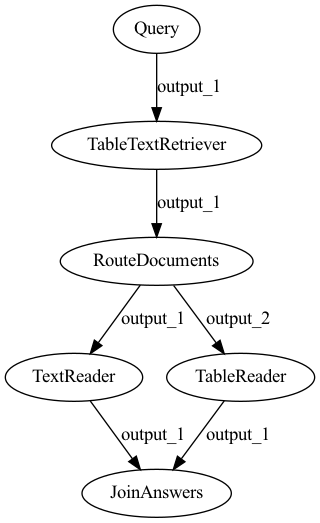

In [18]:
# Let's have a look on the structure of the combined Table an Text QA pipeline.
from IPython import display

text_table_qa_pipeline.draw()
display.Image("pipeline.png")

In [ ]:
# Example query whose answer resides in a text passage
predictions = text_table_qa_pipeline.run(query="Who was Thomas Alva Edison?")

In [20]:
# We can see both text passages and tables as contexts of the predicted answers.
print_answers(predictions, details="minimum")


Query: Who was Thomas Alva Edison?
Answers:
[   {   'answer': 'American inventor and businessman',
        'context': 'mas Alva Edison (February 11, 1847October 18, 1931) was an '
                   'American inventor and businessman, who has been described '
                   "as America's greatest inventor. H"},
    {   'answer': 'Dorothy Colpoys',
        'context':     Year       Men's singles   Women's singles  \
0   1928      Alan Titherley          R. Finch   
1   1929          T. P. Dick  Margaret Tragett   
2   1930         Donald Hume   Dorothy Colpoys   
3   1931          T. P. Dick   Dorothy Colpoys   
4   1932         W. Hamilton  Thelma Kingsbury   
..   ...                 ...               ...   
59  2008      Brice Leverdez      Kati Tolmoff   
60  2009    Kristian Nielsen     Tatjana Bibik   
61  2010         Pablo Abián    Anita Raj Kaur   
62  2011  Niluka Karunaratne   Nicole Schaller   
63  2012      Chou Tien-chen    Chiang Mei-hui   

                         

In [ ]:
# Example query whose answer resides in a table
predictions = text_table_qa_pipeline.run(query="Which country does the film Macaroni come from?")

In [22]:
# We can see both text passages and tables as contexts of the predicted answers.
print_answers(predictions, details="minimum")


Query: Which country does the film Macaroni come from?
Answers:
[   {   'answer': 'Italian',
        'context':    Submitting country Film title used in nomination        Language ( s )  \
0           Argentina            The Official Story               Spanish   
1             Austria                       Malambo                German   
2             Belgium                          Dust                French   
3              Canada          Jacques and November                French   
4      Czechoslovakia              Scalpel , Please                 Czech   
5             Denmark               Twist and Shout                Danish   
6              France        Three Men and a Cradle                French   
7        West Germany                 Angry Harvest                German   
8             Hungary                  Colonel Redl                German   
9             Iceland                   Deep Winter             Icelandic   
10              India                   

## Evaluation
To evaluate our pipeline, we can use haystack's evaluation feature. We just need to convert our labels into `MultiLabel` objects and the `eval` method will do the rest.

In [23]:
from haystack import Label, MultiLabel, Answer


def read_labels(filename, tables):
    processed_labels = []
    with open(filename) as labels:
        labels = json.load(labels)
        for table in tables:
            if table.id not in labels:
                continue
            label = labels[table.id]
            label = Label(
                query=label["query"],
                document=table,
                is_correct_answer=True,
                is_correct_document=True,
                answer=Answer(answer=label["answer"]),
                origin="gold-label",
            )
            processed_labels.append(MultiLabel(labels=[label]))
    return processed_labels


table_labels = read_labels(f"{doc_dir}/labels.json", tables)
passage_labels = read_labels(f"{doc_dir}/labels.json", passages)

In [ ]:
eval_results = text_table_qa_pipeline.eval(table_labels + passage_labels, params={"top_k": 10})

In [25]:
# Calculating and printing the evaluation metrics
print(eval_results.calculate_metrics())

{'JoinAnswers': {'f1': 0.7126190476190477, 'exact_match': 0.6}}


## Adding tables from PDFs
It can sometimes be hard to provide your data in form of a pandas DataFrame. For this case, we provide the `ParsrConverter` wrapper that can help you to convert, for example, a PDF file into a document that you can index.

In [ ]:
!docker run -d -p 3001:3001 axarev/parsr

In [ ]:
!wget https://www.w3.org/WAI/WCAG21/working-examples/pdf-table/table.pdf

In [32]:
from haystack.nodes import ParsrConverter

converter = ParsrConverter()

docs = converter.convert("table.pdf")

tables = [doc for doc in docs if doc["content_type"] == "table"]

In [34]:
print(tables)

[{'content': [['Disability\nCategory', 'Participants', 'Ballots\nCompleted', 'Ballots\nIncomplete/\nTerminated', 'Results', 'Results'], ['Disability\nCategory', 'Participants', 'Ballots\nCompleted', 'Ballots\nIncomplete/\nTerminated', 'Accuracy', 'Time to\ncomplete'], ['Blind', '5', '1', '4', '34.5%, n=1', '1199 sec, n=1'], ['Low Vision', '5', '2', '3', '98.3% n=2\n(97.7%, n=3)', '1716 sec, n=3\n(1934 sec, n=2)'], ['Dexterity', '5', '4', '1', '98.3%, n=4', '1672.1 sec, n=4'], ['Mobility', '3', '3', '0', '95.4%, n=3', '1416 sec, n=3']], 'content_type': 'table', 'meta': {'preceding_context': 'Example table\nThis is an example of a data table.', 'following_context': ''}}]


## About us

This [Haystack](https://github.com/deepset-ai/haystack/) notebook was made with love by [deepset](https://deepset.ai/) in Berlin, Germany

We bring NLP to the industry via open source!  
Our focus: Industry specific language models & large scale QA systems.  
  
Some of our other work: 
- [German BERT](https://deepset.ai/german-bert)
- [GermanQuAD and GermanDPR](https://deepset.ai/germanquad)
- [FARM](https://github.com/deepset-ai/FARM)

Get in touch:
[Twitter](https://twitter.com/deepset_ai) | [LinkedIn](https://www.linkedin.com/company/deepset-ai/) | [Slack](https://haystack.deepset.ai/community/join) | [GitHub Discussions](https://github.com/deepset-ai/haystack/discussions) | [Website](https://deepset.ai)

By the way: [we're hiring!](https://www.deepset.ai/jobs)
